# FFT Convolution and other things

There are two points I want to address in this notebook:

1. FFT convolution and zero padding
2. reflection and conjugation
---
1. http://dsp.stackexchange.com/questions/736/how-do-i-implement-cross-correlation-to-prove-two-audio-files-are-similar
2. http://www.dspguide.com/ch18/2.htm

In [2]:
%pylab inline
import seaborn as sns

from scipy.signal import fftconvolve

Populating the interactive namespace from numpy and matplotlib


## FFT convolution and zero padding

FFT convolution is a little more complicated than the mathematical formula would suggest. Mathematically we have $f \otimes g = \mathcal{F}^{-1}(F \times G)$ where $\mathcal{F}$ represents the fourier transform operation and $f$ and $F$ and $g$ and $G$ are fourier transform pairs.

However, when we perform the calculation numerically we have to remember that our signal is _not_ infinite and that in fact we are performing a _circular convolution_[1, 2]. That means that we have to pad our signal and kernel with enough zeros that this doesn't happen. I haven't been doing this with most of my FFT convolutions. But because I'ave been using small kernels (PSFs are small) and shifting them to begin with I haven't noticed the effect.

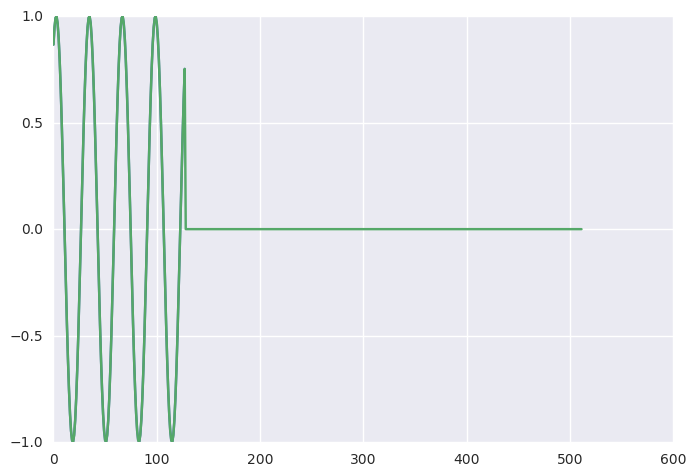

In [16]:
x = arange(128)
y = sin(2 * pi * x / 128 * 4 + pi / 3)
newshape = 512
ytest = irfft(rfft(y))
assert allclose(ytest, y)

y2 = irfft(rfft(y, newshape), newshape)
plot(y)
plot(y2)

In [125]:
i = 8
array((fftshift(fftfreq(i, 1 / i)), fftshift(fftfreq(i, 1 / i)) + i // 2))

array([[-4., -3., -2., -1.,  0.,  1.,  2.,  3.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]])

### Test 1, Normal Centering Even

AssertionError: 

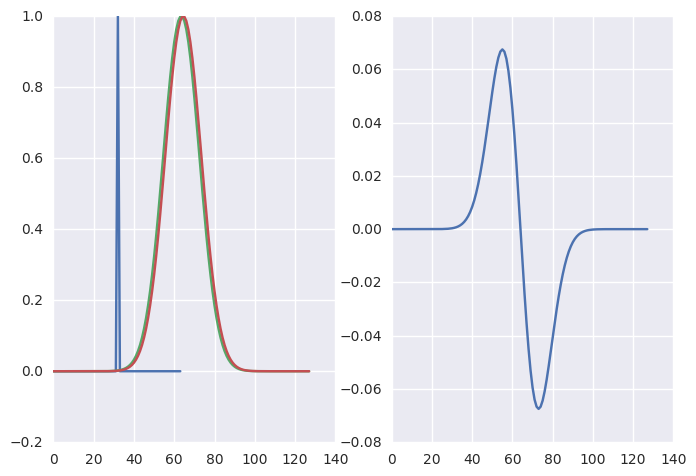

In [136]:
x = linspace(-5, 5, 128, True)
y = exp(-(x**2))

fig, (ax0, ax1) = subplots(1, 2)

imp = arange(64) == 64 // 2
ax0.plot(imp)

conv = fftconvolve(y, imp, "same")
ax0.plot(y)
ax0.plot(conv)
ax1.plot(y - conv)
assert allclose(y, conv)

### Normal Centering, odd

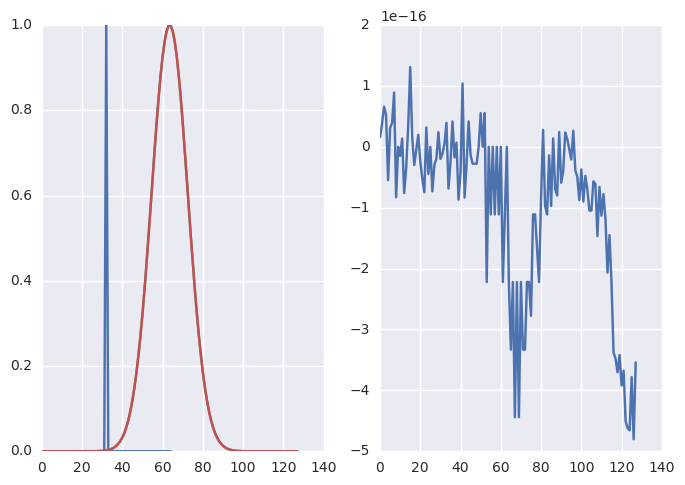

In [139]:
x = linspace(-5, 5, 128, True)
y = exp(-(x**2))

fig, (ax0, ax1) = subplots(1, 2)

imp = arange(65) == 65 // 2
ax0.plot(imp)

conv = fftconvolve(y, imp, "same")
ax0.plot(y)
ax0.plot(conv)
ax1.plot(y - conv)
assert allclose(y, conv)

### Normal centering, even 20 iterations

AssertionError: 

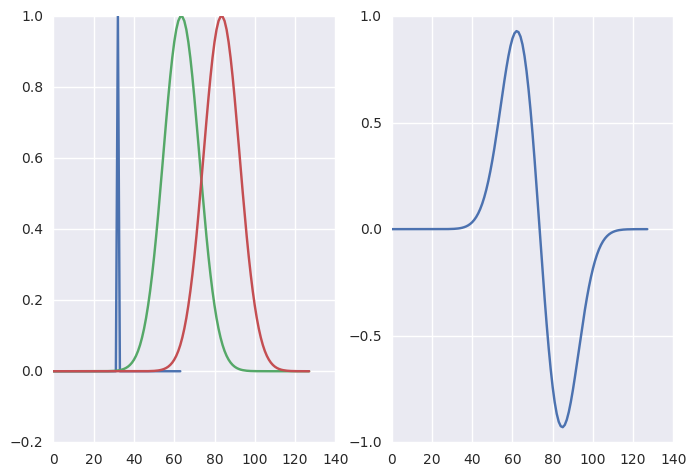

In [141]:
x = linspace(-5, 5, 128, True)
y = exp(-(x**2))

fig, (ax0, ax1) = subplots(1, 2)

imp = arange(64) == 64 // 2
ax0.plot(imp)
conv = y
for i in range(20):
    conv = fftconvolve(conv, imp, "same")
ax0.plot(y)
ax0.plot(conv)
ax1.plot(y - conv)
assert allclose(y, conv)

### Normal Centering, Odd, 20 iterations

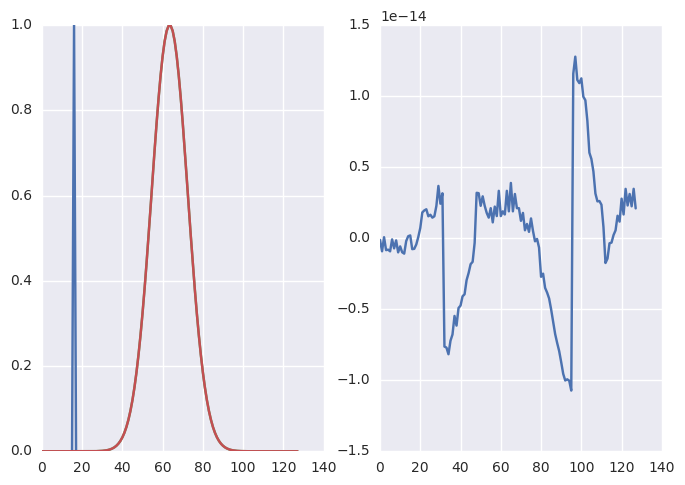

In [142]:
x = linspace(-5, 5, 128, True)
y = exp(-(x**2))

fig, (ax0, ax1) = subplots(1, 2)

imp = arange(33) == 33 // 2
ax0.plot(imp)
conv = y
for i in range(20):
    conv = fftconvolve(conv, imp, "same")
ax0.plot(y)
ax0.plot(conv)
ax1.plot(y - conv)
assert allclose(y, conv)

### Reverse Center, even, 20 iterations

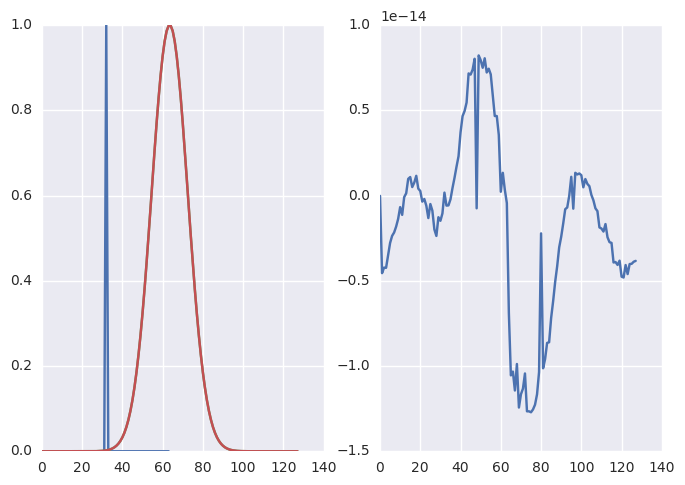

In [143]:
x = linspace(-5, 5, 128, True)
y = exp(-(x**2))

fig, (ax0, ax1) = subplots(1, 2)

imp = arange(64) == 64 // 2
ax0.plot(imp)
conv = y
for i in range(20):
    conv = fftconvolve(conv, imp[::-1], "same")
ax0.plot(y)
ax0.plot(conv)
ax1.plot(y - conv)
assert allclose(y, conv)

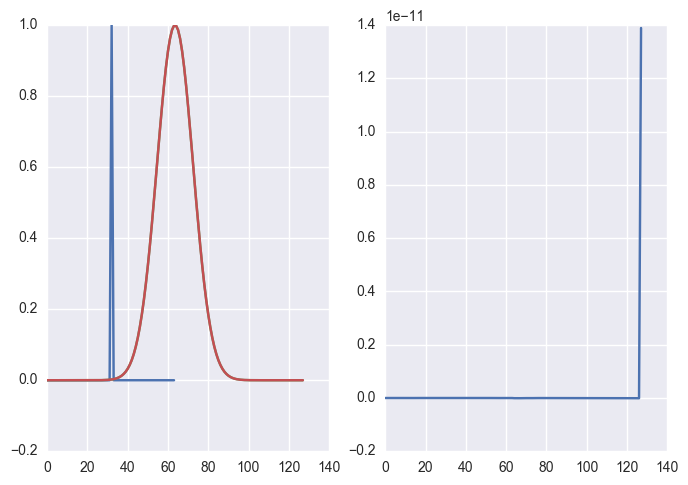

In [4]:
x = linspace(-5, 5, 128, True)
y = exp(-(x**2))

fig, (ax0, ax1) = subplots(1, 2)

imp = arange(64) == 64 // 2
ax0.plot(imp)
conv = y
for i in range(20):
    conv = roll(fftconvolve(conv, imp, "same"), -1)
ax0.plot(y)
ax0.plot(conv)
ax1.plot(y - conv)
assert allclose(y, conv)

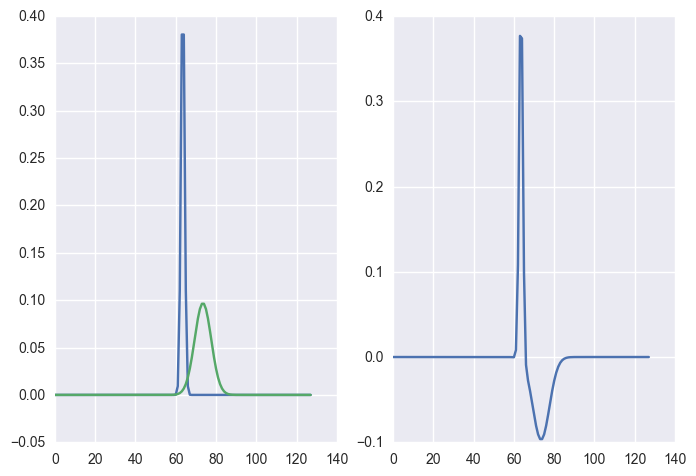

In [30]:
x = linspace(-50, 50, 128, True)
y = exp(-(x**2))
y /= y.sum()

fig, (ax0, ax1) = subplots(1, 2)
conv = y
for i in range(20):
    conv = fftconvolve(conv, y, "same")
ax0.plot(y)
ax0.plot(conv)
ax1.plot(y - conv)
# assert allclose(y, conv)

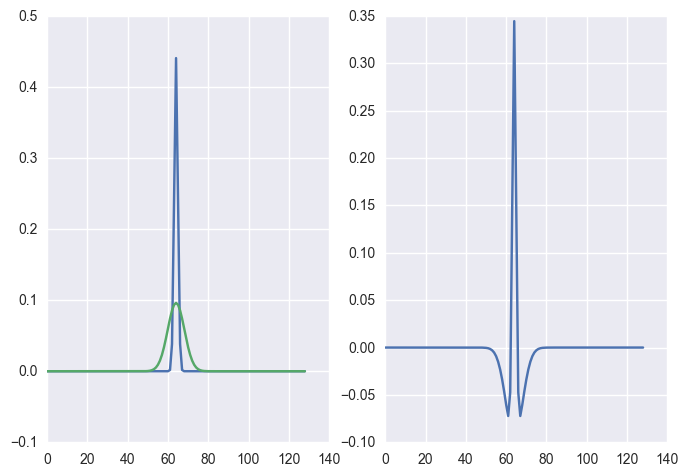

In [44]:
x = linspace(-50, 50, 129, True)
y = exp(-(x**2))
y /= y.sum()

fig, (ax0, ax1) = subplots(1, 2)
conv = roll(y, 0)
for i in range(20):
    conv = fftconvolve(conv, y, "same")
ax0.plot(y)
ax0.plot(conv)
ax1.plot(y - conv)
# assert allclose(y, conv)

## Convolution Check

In [327]:
def crappy_fft_convolve(image, psf):
    """"""
    otf = rfftn(ifftshift((roll(fft_pad(psf, image.shape, mode="constant"), 1))))
    blur = irfftn(otf * rfftn(image), image.shape)
    return blur

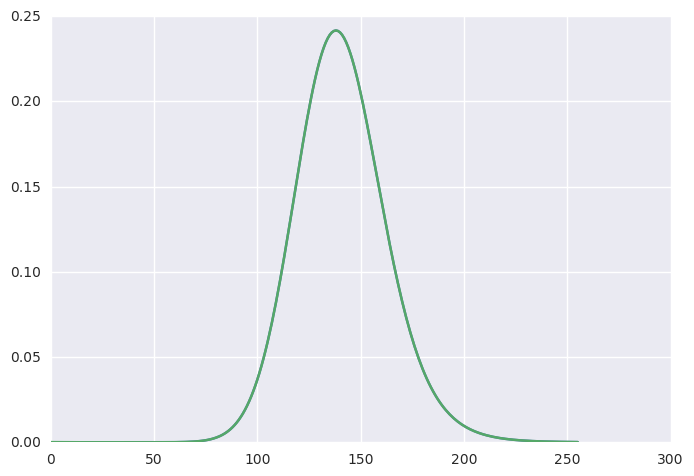

In [328]:
f2 = f  # fft_pad(f, (512), "constant")
y = fftconvolve(f2, k, "same")
y2 = crappy_fft_convolve(f2, k)
plot(y)
plot(y2)

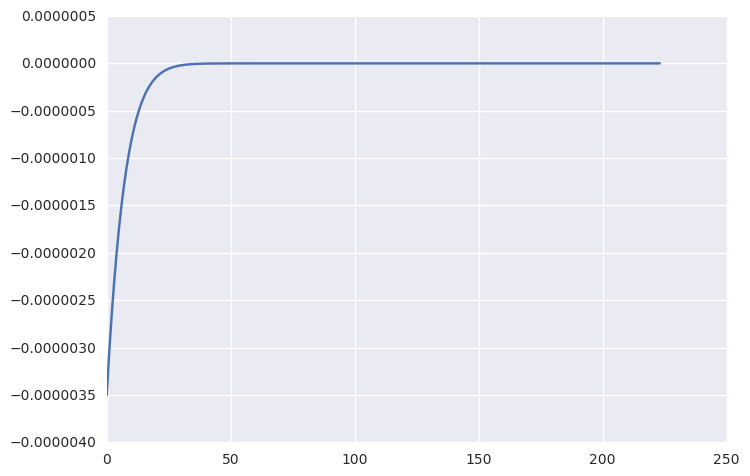

In [329]:
plot((y - y2)[32:])

It seems like the method of padding and then ifftshifting gives _almost_ the same result as a proper fft convolution for a much smaller computational cost. In the design of the package we can offer the user the option to use `fast` or `accurate` computations. If the user chooses fast, we can use the fast core and if the user chooses accurate we can use a core in which the computation is performed using the proper fftconvolution.

## Reflection and conjugation

One other issue that I've come across is that Fourier transforming a signal, taking the conjugate and then inverse Fourier Transformation doesn't reverse the signal, exactly, as it should. It's one sample off.

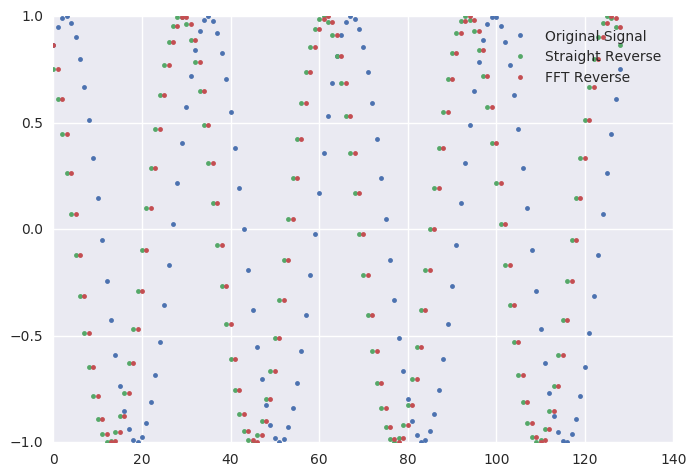

In [99]:
x = arange(129)
y = sin(2 * pi * x / 129 * 4 + pi / 3)
y_rev = y[::-1]
y_rev_fft = irfft(conj(rfft(y, 129)), 129)

plot(y, ".", label="Original Signal")
plot(y_rev, ".", label="Straight Reverse")
plot(y_rev_fft, ".", label="FFT Reverse")
# plot(roll(y_rev_fft, -1), label="FFT Reverse Shift -1")
legend()
savefig("FFT Conjugation Reversal.png")

As you can see the conjugated version _does_ reverse the signal but it is off by one sample. Why is this?

I posed this question on [stackexchange](http://dsp.stackexchange.com/questions/35088/fourier-transform-gives-unexpected-results-signal-reversal-and-conjugation).

The basic answer is that reversing the signal point by point is equivalent to chosing a mirror plane between samples whereas reversing it with the FFT uses an actual sample.

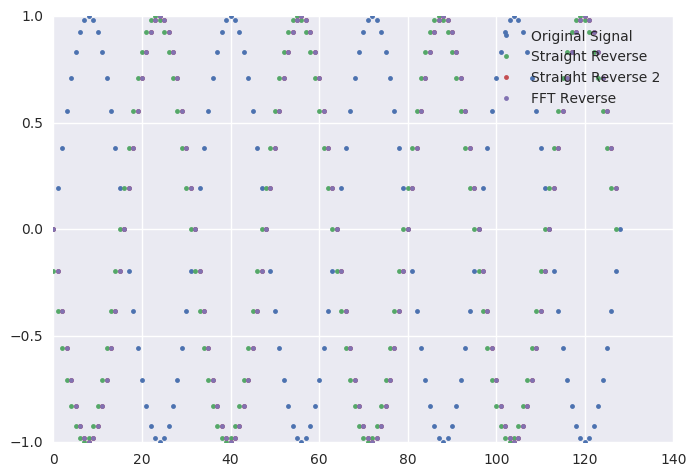

In [384]:
x = arange(128)
y = sin(2 * pi * x / 128 * 4 + pi * 0)
# explicitly reverse about origin
y_rev = y[::-1]
y_rev_fft = irfft(conj(rfft(y)))

x = arange(129)
y = sin(2 * pi * x / 128 * 4 + pi * 0)
y_rev2 = y[:0:-1]

plot(y, ".", label="Original Signal")
plot(y_rev, ".", label="Straight Reverse")
plot(y_rev2, ".", label="Straight Reverse 2")
plot(y_rev_fft, ".", label="FFT Reverse")
# plot(roll(y_rev_fft, -1), label="FFT Reverse Shift -1")
legend()

In [381]:
assert allclose(y_rev2, y_rev_fft)

# Correlation

In [391]:
x = linspace(-30, 30, 512, True)
k = exp(-(x**2))

# k += exp(-(x-2)**2)
k /= k.sum()
x = linspace(-10, 10, 256, True)
f = exp(-x) * (x > 0)
y = fftconvolve(f, k, "same")

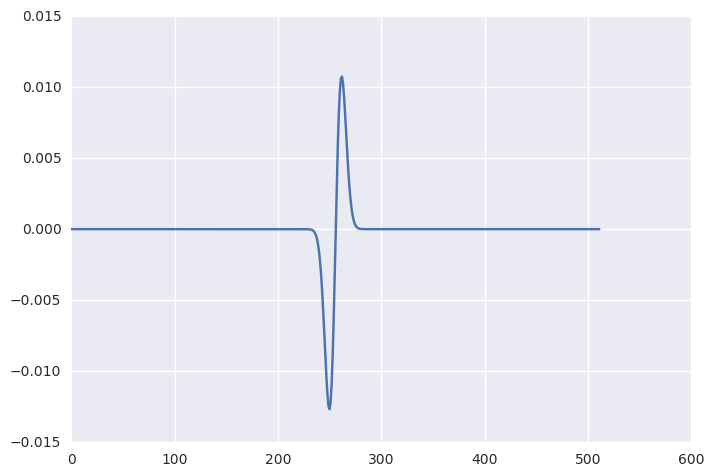

In [401]:
plot(y)

In [10]:
x = arange(513)
f = sin(2 * pi * x / 512 * 4 + pi * 0.25)
y = f

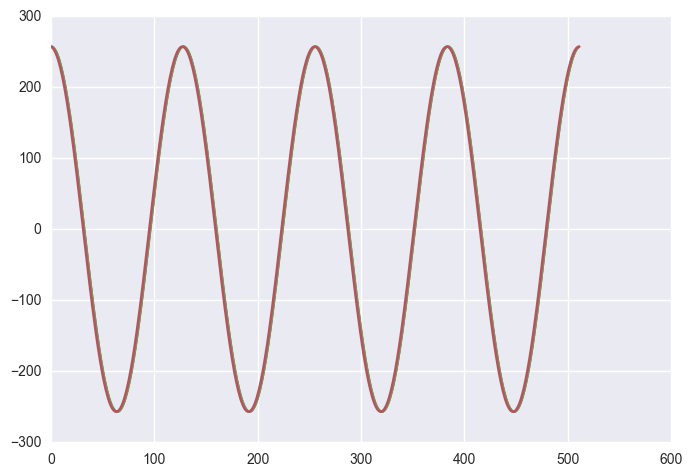

In [11]:
plot(irfft(abs(rfft(y)) ** 2))
plot(irfft(conj(rfft(y)) * rfft(y)))
plot(irfft(rfft(y[::-1]) * rfft(y)))

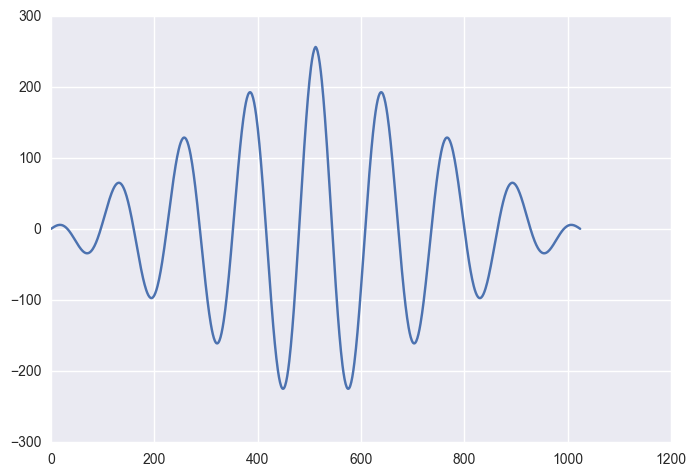

In [12]:
plot(fftconvolve(y[::-1], y))

In [13]:
allclose(irfft(conj(rfft(y)) * rfft(y)), irfft(rfft(y[::-1]) * rfft(y)))

False

In [14]:
allclose(roll(irfft(conj(rfft(y)) * rfft(y)), -1), irfft(rfft(y[::-1]) * rfft(y)))

False

The won't agree when using periodic functions for the same reason that `crappy_fft_convolve` is not correct like `fftconvolve`. But if you have a well isolated signal for either the image or psf the the convolution will work almost correctly.

This has implications for the pyOTF package. The intensity OTF is really the autocorrelation of the amplitude OTF. Right now we just take `OTFa` fourier transform it (to get `PSFa`) and then take the absolute value squared (to get `PSFi`) before inverse transformation to get `OTFi` in reality we'd want to first pad out to double the size.

Actually we do do this, We make sure that the the size of the simulation is `2 * NA / wl` which ensures that we have enough room to perform the convolutions.

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: divide by zero encountered in log
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in log
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: divide by zero encountered in log
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in log


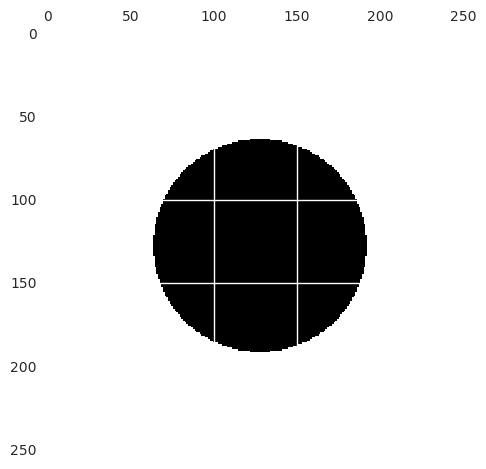

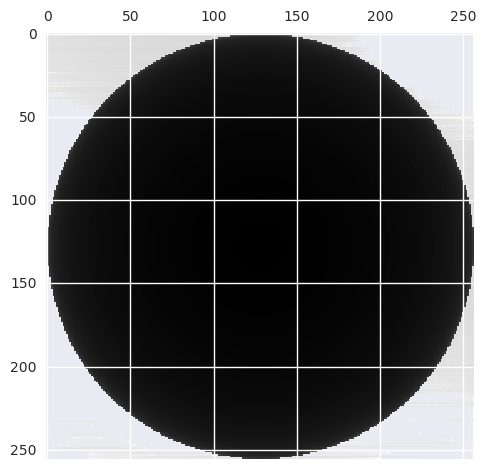

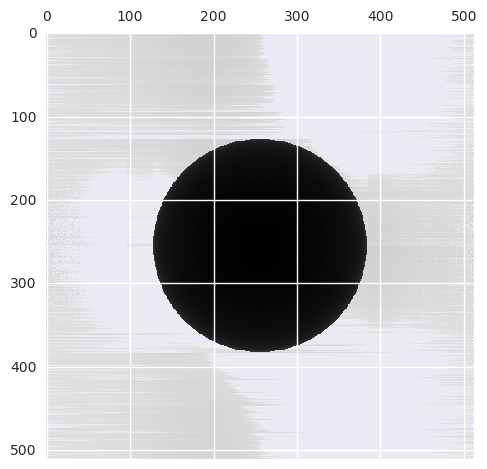

In [421]:
x = linspace(-1, 1, 256)
r = hypot(*meshgrid(x, x))
circ = r < 0.5
matshow(circ)
matshow(log(fftconvolve(circ, circ, "same")))
matshow(log(fftconvolve(circ, circ)))

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: divide by zero encountered in log
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in log


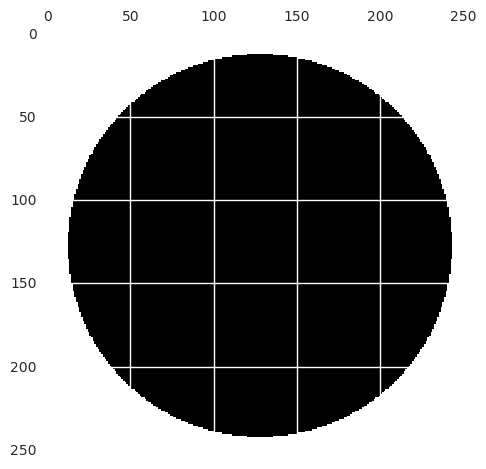

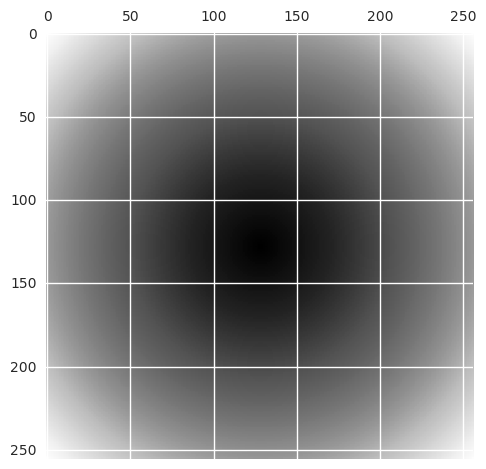

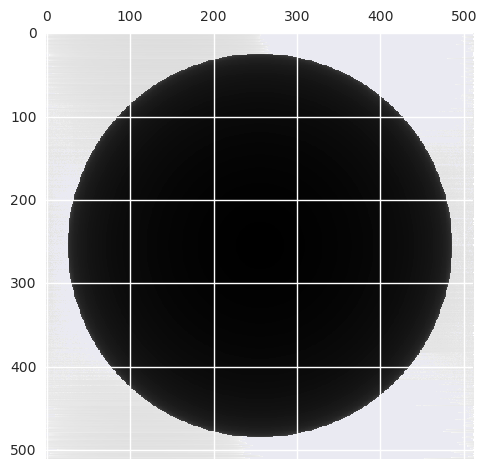

In [423]:
x = linspace(-1, 1, 256)
r = hypot(*meshgrid(x, x))
circ = r < 0.9
matshow(circ)
matshow(log(fftconvolve(circ, circ, "same")))
matshow(log(fftconvolve(circ, circ)))

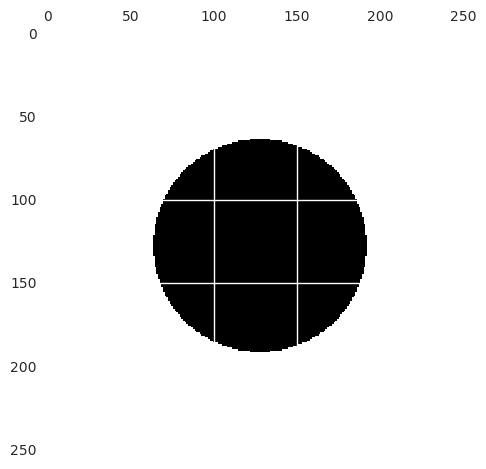

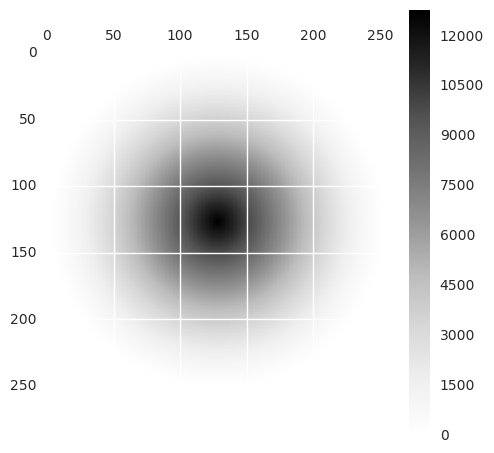

In [429]:
x = linspace(-1, 1, 256)
r = hypot(*meshgrid(x, x))
circ = r < 0.5
matshow(circ)
matshow((crappy_fft_convolve(circ, circ)))
colorbar()

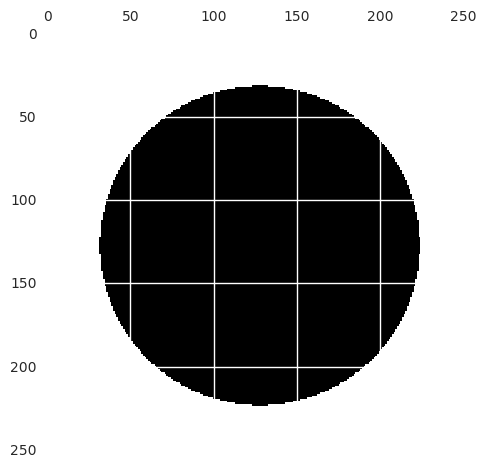

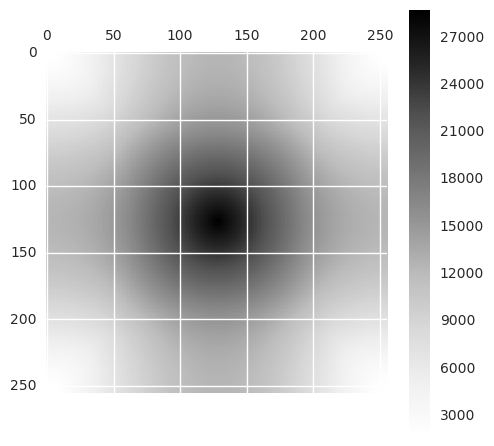

In [430]:
x = linspace(-1, 1, 256)
r = hypot(*meshgrid(x, x))
circ = r < 0.75
matshow(circ)
matshow((crappy_fft_convolve(circ, circ)))
colorbar()

### Need to roll

You need to roll back the result of the autocorrelation to get the same result.

In explanation: mathematically speaking you have for a 

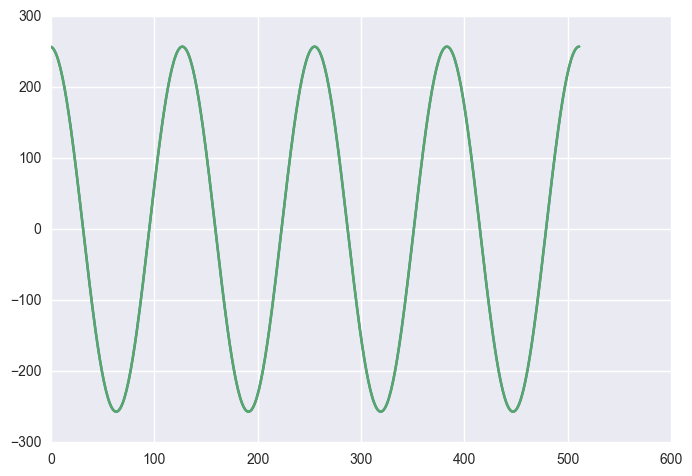

In [15]:
plot(roll(irfft(conj(rfft(y)) * rfft(y)), -1))
plot(irfft(rfft(y[::-1]) * rfft(y)))

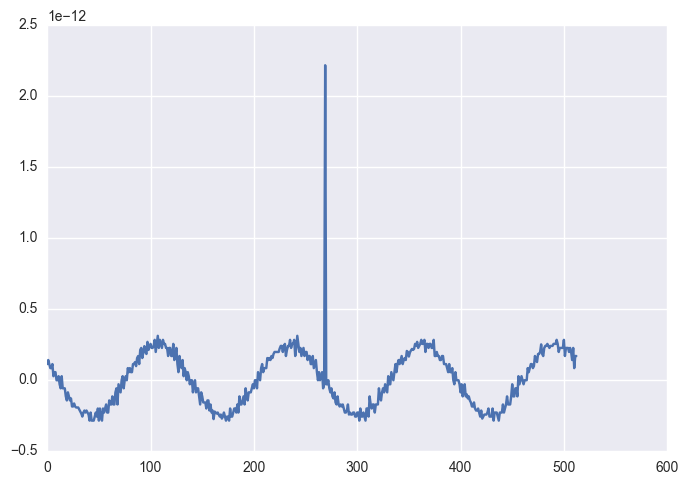

In [26]:
plot(roll(irfft(conj(rfft(y)) * rfft(y), 513), -1) - irfft(rfft(y[::-1]) * rfft(y), 513))